# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для компании, разрабатывающей решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении есть данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Основными этапами нашего проекта станут:

* Загрузка и подготовка данных
* Проверка расчета эффективности обогащения
* Анализ признаков, недоступных в тестовой выборке
* Предобработка данных
* Анализ концентраций разных металлов на различных этапах очистки
* Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках
* Исследование суммарной концентрации всех веществ на разных стадиях
* Создание функции для вычисления итоговой sMAPE
* Обучение разных моделей и оценка их качества кросс-валидацией. Выбор лучшей модели.
  
Проект выполнен в **Jupyter Notebook**, версия сервера блокнотов: 6.1.4. Версия **Python** 3.7.8.
В проекте использованы библиотеки 
* **Pandas** 
* **NumPy**
* **scikit-learn**
* **IPython**

## Подготовка данных

In [1]:
# Импортируем необходимые для выполнения проекта библиотеки и модули.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

# Прочитаем и изучим данные.
data = pd.read_csv('/datasets/gold_recovery_full_new.csv')
train_data = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test_data = pd.read_csv('/datasets/gold_recovery_test_new.csv')

def describe(data):
    print('Размеры таблицы составляют', data.shape)
    print()
    data.info()
    pd.set_option('display.max_columns', None)
    display(data)
    print('Количество полных дубликатов', data.duplicated().sum())

describe(data)

Размеры таблицы составляют (19439, 87)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol               

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Количество полных дубликатов 0


In [2]:
describe(train_data)

Размеры таблицы составляют (14149, 87)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol               

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Количество полных дубликатов 0


Размер тренировочной выборки составляет примерно 73 % от исходного датасета, что вполне допустимо.

In [3]:
describe(test_data)

Размеры таблицы составляют (5290, 53)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      52

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

Количество полных дубликатов 0


Необходимо дать словесное определение каждому признаку, упорядочить его. Это позволит нам эффективнее работать с данными. Приступим.

**Дата**  

`date` — дата и время снятия показаний  
  
**Флотация**  


*Расчетные параметры*  

`rougher.calculation.sulfate_to_au_concentrate` — расчетная концентрация сульфатов, добавляемых к золоту на стадии флотации  
`rougher.calculation.floatbank10_sulfate_to_au_feed` — расчетное количество сырья, подаваемого во флотационную установку № 10 для соединения сульфата с золотом  
`rougher.calculation.floatbank11_sulfate_to_au_feed` — расчетное количество сырья, подаваемого во флотационную установку № 11 для соединения сульфата с золотом
`rougher.calculation.au_pb_ratio` — расчетное соотношение золота к свинцу на этапе флотации  

*Параметры на входе*  

`rougher.input.feed_ag` — количество серебра в сырье перед этапом флотации  
`rougher.input.feed_pb` — количество свинца в сырье перед этапом флотации  
`rougher.input.feed_rate` — скорость подачи сырья перед этапом флотации  
`rougher.input.feed_size` — размер гранул сырья перед этапом флотации  
`rougher.input.feed_sol` — количество соли в сырье перед этапом флотации  
`rougher.input.feed_au` — количество золота в сырье перед этапом флотации  
`rougher.input.floatbank10_sulfate` — количество сульфата в сырье, находящимся во флотационной установке № 10, перед этапом флотации  
`rougher.input.floatbank10_xanthate` — количество ксантогената в сырье, находящимся во флотационной установке № 10, перед этапом флотации  
`rougher.input.floatbank11_sulfate` — количество сульфата в сырье, находящимся во флотационной установке № 11, перед этапом флотации  
`rougher.input.floatbank11_xanthate` — количество ксантогената в сырье, находящимся во флотационной установке № 11, перед этапом флотации 
  
*Состояние во время процесса*  
  
`rougher.state.floatbank10_a_air` — объем воздуха на этапе "a" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_a_level` — уровень жидкости на этапе "a" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_b_air` — объем воздуха на этапе "b" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_b_level` — уровень жидкости на этапе "b" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_c_air` — объем воздуха на этапе "c" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_c_level` — уровень жидкости на этапе "c" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_d_air` — объем воздуха на этапе "d" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_d_level` — уровень жидкости на этапе "d" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_e_air` — объем воздуха на этапе "e" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_e_level` — уровень жидкости на этапе "e" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_f_air` — объем воздуха на этапе "f" во флотационной установке № 8 во время флотации  
`rougher.state.floatbank10_f_level` — уровень жидкости на этапе "f" во флотационной установке № 8 во время флотации  
  
*Параметры на выходе*  
  
`rougher.output.concentrate_ag` — концентрация серебра в продукте после флотации  
`rougher.output.concentrate_pb` — концентрация свинца в продукте после флотации  
`rougher.output.concentrate_sol` — концентрация солей в продукте после флотации  
`rougher.output.concentrate_au` — концентрация золота в продукте после флотации  
`rougher.output.recovery` — эффективность обогащения сырья после флотации  
`rougher.output.tail_ag` — масса серебра в отвальных хвостах после флотации  
`rougher.output.tail_pb` — масса свинца в отвальных хвостах после флотации  
`rougher.output.tail_sol` — масса солей в отвальных хвостах после флотации    
`rougher.output.tail_au` — масса золота в отвальных хвостах после флотации  
 
  
**Первичная очистка**  
  
*Параметры на входе* 

`primary_cleaner.input.sulfate` — количество сульфатов на стадии первичной очистки сырья  
`primary_cleaner.input.depressant` — количество депрессантов на стадии первичной очистки сырья  
`primary_cleaner.input.feed_size` — размер сырья на стадии первичной очистки сырья  
`primary_cleaner.input.depressant` — количество ксантогенатов на стадии первичной очистки сырья  
  
*Состояние во время процесса*  
  
`primary_cleaner.state.floatbank8_a_air` — объем воздуха на этапе "a" во флотационной установке № 8 во время перивчной очистки сырья  
`primary_cleaner.state.floatbank8_a_level` — уровень жидкости на этапе "a" во флотационной установке № 8 во время перивчной очистки сырья  
`primary_cleaner.state.floatbank8_b_air` — объем воздуха на этапе "b" во флотационной установке № 8 во время перивчной очистки сырья  
`primary_cleaner.state.floatbank8_b_level` — уровень жидкости на этапе "b" во флотационной установке № 8 во время перивчной очистки сырья  
`primary_cleaner.state.floatbank8_c_air` — объем воздуха на этапе "c" во флотационной установке № 8 во время перивчной очистки сырья  
`primary_cleaner.state.floatbank8_c_level` — уровень жидкости на этапе "c" во флотационной установке № 8 во время перивчной очистки сырья  
`primary_cleaner.state.floatbank8_d_air` — объем воздуха на этапе "d" во флотационной установке № 8 во время перивчной очистки сырья  
`primary_cleaner.state.floatbank8_d_level` — уровень жидкости на этапе "d" во флотационной установке № 8 во время перивчной очистки сырья    
  
*Параметры на выходе*   
  
`primary_cleaner.output.concentrate_ag` — концентрация серебра в продукте после первичной очистки сырья  
`primary_cleaner.output.concentrate_pb` — финальная концентрация свинца в продукте после первичной очистки сырья 
`primary_cleaner.output.concentrate_sol` — финальная концентрация солей в продукте после первичной очистки сырья 
`primary_cleaner.output.concentrate_au` — финальная концентрация золота в продукте после первичной очистки сырья  
`primary_cleaner.output.tail_ag` — масса серебра в отвальных хвостах после первичной очистки сырья  
`primary_cleaner.output.tail_pb` — масса свинца в отвальных хвостах после первичной очистки сырья  
`primary_cleaner.output.tail_sol` — масса солей в отвальных хвостах после первичной очистки сырья  
`primary_cleaner.output.tail_au` — масса золота в отвальных хвостах после первичной очистки сырья  

  
**Вторичная очистка**  
  
*Состояние во время процесса*  

`secondary_cleaner.state.floatbank2_a_air` — объем воздуха на этапе "a" во флотационной установке № 2 во время вторичной очистки    
`secondary_cleaner.state.floatbank2_a_level` — уровень жидкости на этапе "a" во флотационной установке № 2 во время вторичной очистки  
`secondary_cleaner.state.floatbank2_b_air` — объем воздуха на этапе "b" во флотационной установке № 2 во время вторичной очистки    
`secondary_cleaner.state.floatbank2_b_level` — уровень жидкости на этапе "b" во флотационной установке № 2 во время вторичной очистки  
`secondary_cleaner.state.floatbank3_a_air` — объем воздуха на этапе "a" во флотационной установке № 3 во время вторичной очистки    
`secondary_cleaner.state.floatbank3_a_level` — уровень жидкости на этапе "a" во флотационной установке № 3 во время вторичной очистки  
`secondary_cleaner.state.floatbank3_b_air` — объем воздуха на этапе "b" во флотационной установке № 3 во время вторичной очистки    
`secondary_cleaner.state.floatbank3_b_level` — уровень жидкости на этапе "b" во флотационной установке № 3 во время вторичной очистки  
`secondary_cleaner.state.floatbank4_a_air` — объем воздуха на этапе "a" во флотационной установке № 4 во время вторичной очистки    
`secondary_cleaner.state.floatbank4_a_level` — уровень жидкости на этапе "a" во флотационной установке № 4 во время вторичной очистки  
`secondary_cleaner.state.floatbank4_b_air` — объем воздуха на этапе "b" во флотационной установке № 4 во время вторичной очистки    
`secondary_cleaner.state.floatbank4_b_level` — уровень жидкости на этапе "b" во флотационной установке № 4 во время вторичной очистки  
`secondary_cleaner.state.floatbank5_a_air` — объем воздуха на этапе "a" во флотационной установке № 5 во время вторичной очистки    
`secondary_cleaner.state.floatbank5_a_level` — уровень жидкости на этапе "a" во флотационной установке № 5 во время вторичной очистки  
`secondary_cleaner.state.floatbank5_b_air` — объем воздуха на этапе "b" во флотационной установке № 5 во время вторичной очистки    
`secondary_cleaner.state.floatbank5_b_level` — уровень жидкости на этапе "b" во флотационной установке № 5 во время вторичной очистки  
`secondary_cleaner.state.floatbank6_a_air` — объем воздуха на этапе "a" во флотационной установке № 6 во время вторичной очистки    
`secondary_cleaner.state.floatbank6_a_level` — уровень жидкости на этапе "a" во флотационной установке № 6 во время вторичной очистки  

*Параметры на выходе*  

`secondary_cleaner.output.tail_ag` — масса серебра в отвальных хвостах после вторичной очистки    
`secondary_cleaner.output.tail_pb` — масса свинца в отвальных хвостах после вторичной очистки   
`secondary_cleaner.output.tail_sol` — масса солей в отвальных хвостах после вторичной очистки   
`secondary_cleaner.output.tail_au` — масса золота в отвальных хвостах после вторичной очистки   


**Финальные характеристики**  

*Параметры на выходе*  

`final.output.concentrate_ag` — финальная концентрация серебра в продукте  
`final.output.concentrate_pb` — финальная концентрация свинца в продукте  
`final.output.concentrate_sol` — финальная концентрация солей в продукте  
`final.output.concentrate_au` — финальная концентрация золота в продукте  
`final.output.recovery` — эффективность обогащения финального концентрата  
`final.output.tail_ag` — финальная масса серебра в отвальных хвостах  
`final.output.tail_pb` — финальная масса свинца в отвальных хвостах  
`final.output.tail_sol` — финальная масса солей в отвальных хвостах  
`final.output.tail_au` — финальная масса золота в отвальных хвостах  

In [4]:
# Проверим на тренировочной выборке, что эффективность 
# обогащения рассчитана правильно.
# C — это rougher.output.concentrate_au
# F — это rougher.input.feed_au  
# T — это rougher.output.tail_au
# Напишем функцию, рассчитывающую эффективность обогащения. 
# Затем сохраним результаты её работы в отдельном 
# столбце rougher.calculation.recovery.
def recovery_calc(data):
    c = data['rougher.output.concentrate_au']
    f = data['rougher.input.feed_au']
    t = data['rougher.output.tail_au']
    recovery = ((c * (f - t)) / (f * (c - t))) * 100
    return recovery

train_data['rougher.calculation.recovery'] = train_data.apply(
    recovery_calc, axis=1
)
print(
    'MAE между расчётной эффективностью обогащения и фактическим' +
    'значением составляет', mean_absolute_error(
        train_data['rougher.calculation.recovery'],
        train_data['rougher.output.recovery']
     )
)

MAE между расчётной эффективностью обогащения и фактическимзначением составляет 9.73512347450521e-15


Проведя расчет MAE между расчётной эффективностью обогащения и фактическим значением, мы убедились в том, что предоставленная нам эффективность обогащения `rougher.output.recovery` рассчитана правильно.

Можно заметить, что в тестовой выборке многие признаки отсутствуют. Выявим пропущенные признаки и постараемся определить причину их отсутствия.  
В тестовой выборке отсутствуют:  
* Признаки этапа *final*. Полностью.
* В этапе *rougher* отсутствуют расчетные данные параметра *calculation*, а также выходные данные продукта в параметре *output* (в том числе и об отвальных хвостах)  
* В этапе *primary_cleaner* отсутствуют выходные данные продукта в параметре *output* (в том числе и об отвальных хвостах)
* В этапе *secondary_cleaner* отсутствуют входные и выходные данные сырья и продукта в параметрах *input* и *output* соответственно (в том числе и об отвальных хвостах)  
  
Рассмотрев отсутствующие в тестовой выборке признаки, можно сделать вывод, что их отсутствие обуславливается поставленной перед нами задачей. В тренировочной выборке присутствуют все типы данных: и те, которые нам известны до начала процесса получения золота из руды, и те, которые мы получаем во время процесса и после него. Наша же задача заключается в построении модели, которая должна будет предсказать коэффициент восстановления золота из золотосодержащей руды, основываясь исключительно на исходных данных, которые известны только до начала процесса восстановления. Такая модель позволит нам принимать решение, запускать ли новое производство или нет, ориентируясь на результаты её работы. Качество модели, её работа оцениваются в условиях, моделирующих реальность. Именно поэтому тестовая выборка не должна иметь признаки, отражающие сам процесс и его результат. 


Чтобы приступить к анализу данных и построению модели, нам нужно заполнить пропуски, имеющиеся в тренировочном наборе данных. Займемся этим.

In [5]:
# Заполним пропуски в столбцах, воспользовавшись методом fillna.
# Так как соседние по времени значения похожи друг на друга, мы
# можем заполнить пропуски предыдущим соседним значением.
# Для этого воспользуемся параметром ffill.
# Сначала убедимся, что первая строка датафрейма не имеет пропусков.
display(train_data[:1].isna().sum(axis=1))
# Теперь заменим пропуски на соседние значения
train_data = train_data.fillna(method='ffill')
# Заменим пропуски в тестовой выборке
test_data = test_data.fillna(method='ffill')
# Заменим пропуски в основном наборе
data = data.fillna(method='ffill')
# В качестве индекса сделаем столбец date. 
# Это пригодится позже при тестировании моделей
data = data.set_index('date')
train_data = train_data.set_index('date')
test_data = test_data.set_index('date')

0    0
dtype: int64

### Вывод

Мы провели обработку данных:  
* Прочитали и изучили датасеты. Оценили их размеры. Проверили их на наличие полных дубликатов. 
* Дали словесное определение каждого признака на русском языке.  
* Проверили на тренировочной выборке правильность расчета эффективности обогащения. Данный параметр рассчитан верно. 
* Выявили пропущенные признаки в тестовой выборке и объяснили, почему они отсутствуют. Они отсутствуют, так как модель, которую мы должны создать, должна давать предсказания, опираясь только на исходные данные, известные исключительно только до начала процесса разработки руды.  
* Критически важной частью подготовки наборов данных к построению моделей является избавление от пропущенных значений. Так как соседние по времени параметры часто похожи, мы заменили `NaN`-значения на предыдущие значения.

Следующим шагом выполнения проекта станет анализ данных. Нам предстоит:  
* Рассмотреть как изменяется концентрация металлов на различных этапах очистки  
* Сравнить распределения размеров гранул сырья в тренировочной и тестовой выборках  
* Исследовать суммарную концентрацию всех веществ на разных стадиях

## Анализ данных

In [6]:
# Напишем функцию description, позволяющую быстро исследовать значения.
def description(table, parameter):
    table.plot(y=parameter, 
               kind='box', 
               grid=True, 
               figsize=(15,5)
              )
    plt.title('Диаграмма размаха данных по столбцу '+ str(parameter))
    plt.show()
    table.plot(y=parameter, 
          kind='hist', 
          grid=True, 
          bins=140, 
          figsize=(15,5)
         )
    plt.title('Гистограмма по столбцу ' + str(parameter) + 
              ' количество корзин 140')
    plt.show()
    display(table[parameter].describe())
    display(table[parameter].value_counts())

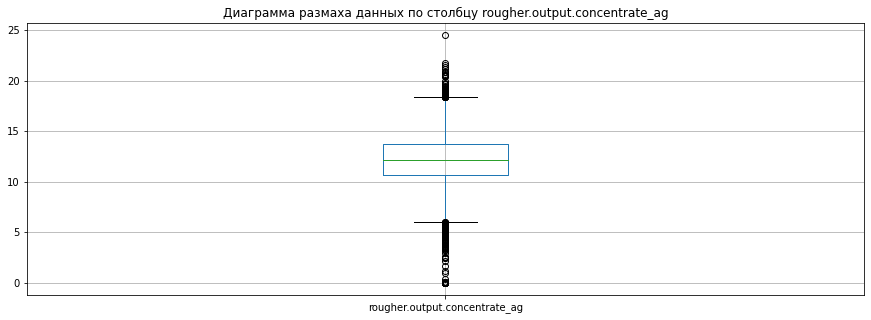

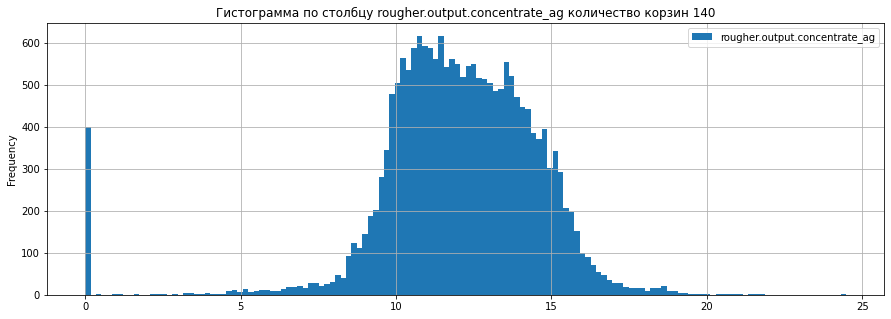

count    19439.000000
mean        11.994759
std          2.733862
min          0.000000
25%         10.628337
50%         12.098115
75%         13.736996
max         24.480271
Name: rougher.output.concentrate_ag, dtype: float64

0.000000     394
7.458753      11
9.252737       6
9.975555       6
0.010000       5
            ... 
12.603623      1
7.610059       1
13.353075      1
12.803057      1
10.304030      1
Name: rougher.output.concentrate_ag, Length: 19015, dtype: int64

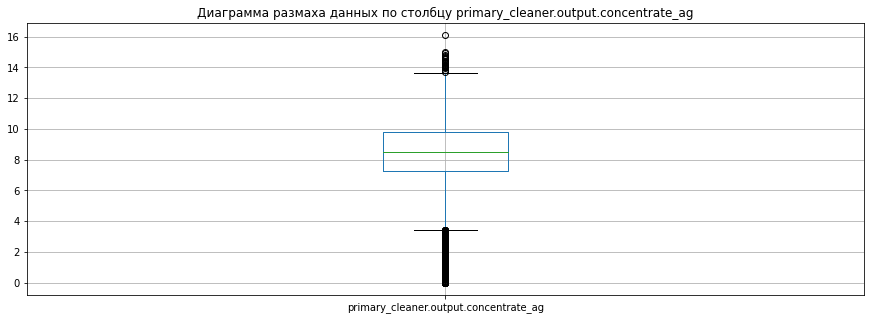

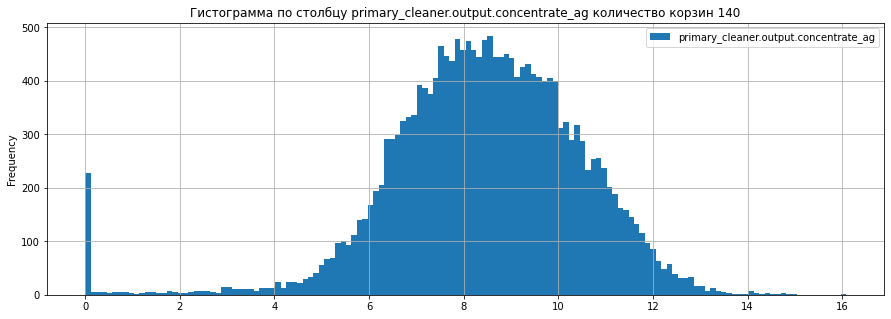

count    19439.000000
mean         8.442408
std          2.054465
min          0.000000
25%          7.263288
50%          8.507298
75%          9.809001
max         16.081632
Name: primary_cleaner.output.concentrate_ag, dtype: float64

0.010000    117
0.000000    108
8.339732      6
7.925334      5
9.987871      5
           ... 
8.361700      1
7.620419      1
6.205785      1
8.954860      1
9.844056      1
Name: primary_cleaner.output.concentrate_ag, Length: 19199, dtype: int64

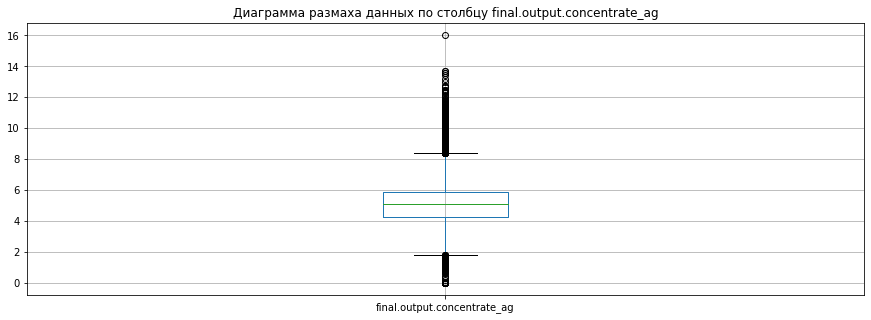

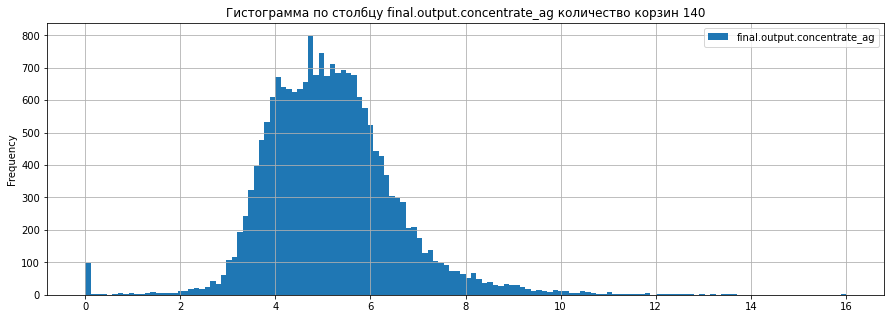

count    19439.000000
mean         5.168387
std          1.372362
min          0.000000
25%          4.251000
50%          5.066039
75%          5.895401
max         16.001945
Name: final.output.concentrate_ag, dtype: float64

0.000000    98
5.925380    11
3.554558     7
3.572025     6
5.955403     5
            ..
6.703167     1
4.707040     1
4.932490     1
4.112471     1
4.334761     1
Name: final.output.concentrate_ag, Length: 19307, dtype: int64

In [7]:
# Начнем с анализа концентрации серебра на каждом этапе.
parameters = [
    'rougher.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_ag',          
    'final.output.concentrate_ag'
]
for element in parameters:
    description(data, element)

**Серебро**  
На всех стадиях значения концентрации серебра распределены нормально. В каждом распределении присутствует аномалия в виде пиков на нулевых значениях. Например, по итогам стадии *rougher* мы видим 394 нулевых значения концентрации серебра. При этом по итогам следующей стадии (*primary_cleaner*) концентрация серебра в этих строках больше нуля. Можно сделать предположение, что появление нулей оправдано и обусловлено непрерывностью процесса обогащения руды. Например, в момент снятия показаний новая партия сырья просто еще не прошла процесс флотации.
  
*Рассмотрим концентрации:*
* Флотация. Медианное значение концентрации серебра: 12,1 %
* Первичная очистка. Медианное значение концентрации серебра: 8,5 %
* Финальный концентрат. Медианное значение концентрации серебра: 5,1 %

In [8]:
# Зафиксируем результаты в виде таблицы.
ag_concentrate = pd.DataFrame(
    {
        'Флотация': [data['rougher.output.concentrate_ag'].median()], 
        'Первичная очистка': [
            data['primary_cleaner.output.concentrate_ag'].median()
        ], 
        'Финальный концентрат': [
            data['final.output.concentrate_ag'].median()
        ]
    }, 
    index=[
        'Медианное значение концентрации серебра'
    ]
)
display(ag_concentrate)

,Флотация,Первичная очистка,Финальный концентрат
Медианное значение концентрации серебра,12.098115,8.507298,5.066039


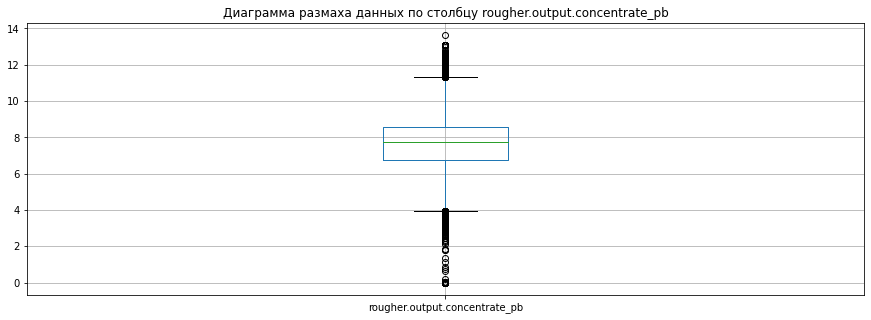

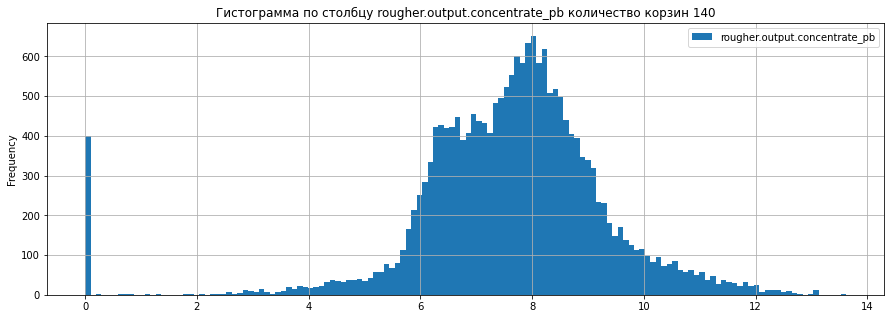

count    19439.000000
mean         7.606272
std          1.796757
min          0.000000
25%          6.725987
50%          7.742580
75%          8.565199
max         13.617072
Name: rougher.output.concentrate_pb, dtype: float64

0.000000     394
13.077148     11
8.452148       8
10.452148      7
9.764648       6
            ... 
7.095515       1
7.504966       1
6.577116       1
6.756150       1
8.700049       1
Name: rougher.output.concentrate_pb, Length: 18956, dtype: int64

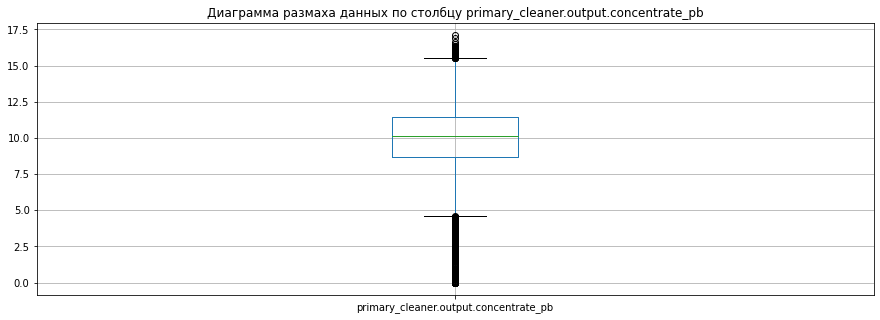

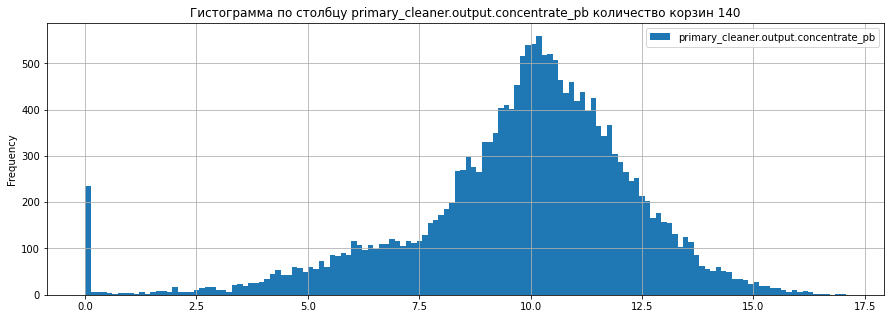

count    19439.000000
mean         9.810317
std          2.572253
min          0.000000
25%          8.676500
50%         10.142270
75%         11.416298
max         17.081278
Name: primary_cleaner.output.concentrate_pb, dtype: float64

0.010000     118
0.000000     114
5.055124       7
10.952148      6
5.587420       6
            ... 
8.730603       1
12.906584      1
7.282277       1
10.741632      1
9.759185       1
Name: primary_cleaner.output.concentrate_pb, Length: 19055, dtype: int64

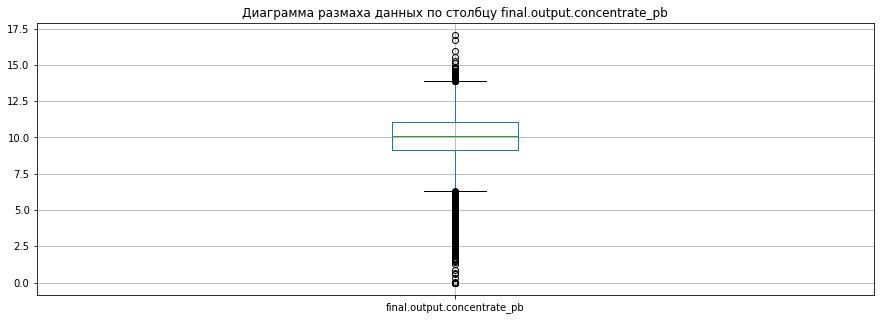

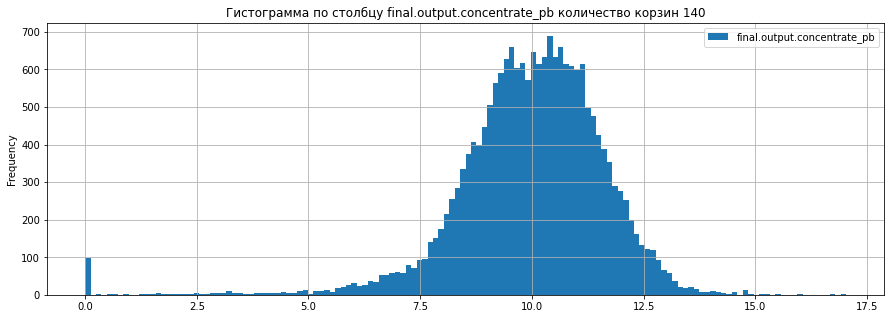

count    19439.000000
mean         9.978821
std          1.669228
min          0.000000
25%          9.137225
50%         10.102264
75%         11.035644
max         17.031899
Name: final.output.concentrate_pb, dtype: float64

0.000000     98
14.764648    11
11.452148     8
12.202148     7
12.577148     6
             ..
10.363694     1
9.172506      1
10.754769     1
11.650345     1
9.521703      1
Name: final.output.concentrate_pb, Length: 19276, dtype: int64

In [9]:
# Проанализируем концентрацию свинца на каждом этапе.
parameters = [
    'rougher.output.concentrate_pb', 
    'primary_cleaner.output.concentrate_pb',          
    'final.output.concentrate_pb'
]
for element in parameters:
    description(data, element)

**Свинец**  
На всех стадиях значения концентрации свинца распределены нормально. В каждом распределении присутствует аномалия в виде пиков на нулевых значениях (как и в случае с серебром). Можно сделать предположение, что появление нулей оправдано и обусловлено непрерывностью процесса обогащения руды. Например, в момент снятия показаний новая партия сырья просто еще не прошла процесс флотации.
  
*Рассмотрим концентрации:*
* Флотация. Медианное значение концентрации свинца: 7,7 %
* Первичная очистка. Медианное значение концентрации свинца: 10,15 %
* Финальный концентрат. Медианное значение концентрации свинца: 10,1 %  
  
Различий в концентрации свинца между первичной очисткой и финальным концентратом практически нет.

In [10]:
# Зафиксируем результаты в виде таблицы.
pb_concentrate = pd.DataFrame(
    {
        'Флотация': [data['rougher.output.concentrate_pb'].median()], 
        'Первичная очистка': [
            data['primary_cleaner.output.concentrate_pb'].median()
        ], 
        'Финальный концентрат': [
            data['final.output.concentrate_pb'].median()
        ]
    }, 
    index=[
        'Медианное значение концентрации свинца'
    ]
)
display(pb_concentrate)

,Флотация,Первичная очистка,Финальный концентрат
Медианное значение концентрации свинца,7.74258,10.14227,10.102264


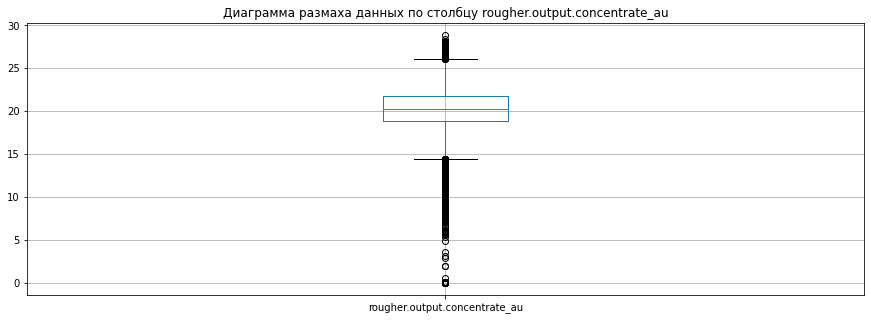

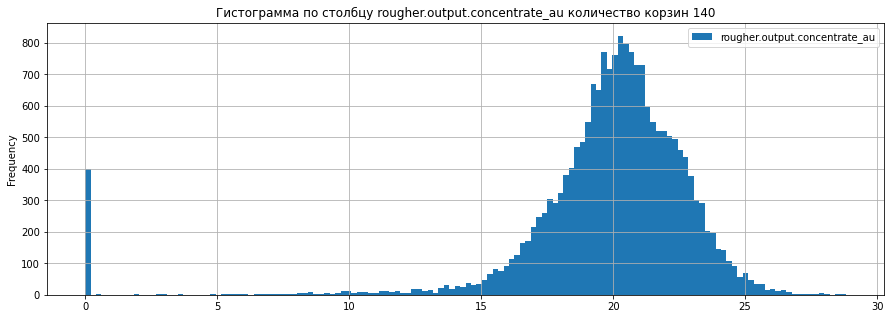

count    19439.000000
mean        19.772000
std          3.753600
min          0.000000
25%         18.802523
50%         20.280214
75%         21.717843
max         28.824507
Name: rougher.output.concentrate_au, dtype: float64

0.000000     394
13.791368     11
20.341888      6
18.652372      6
0.010000       5
            ... 
19.622257      1
18.384403      1
20.725496      1
23.975396      1
20.557015      1
Name: rougher.output.concentrate_au, Length: 19015, dtype: int64

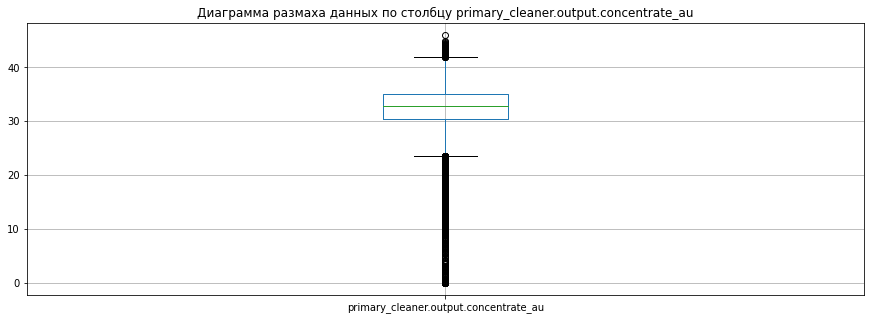

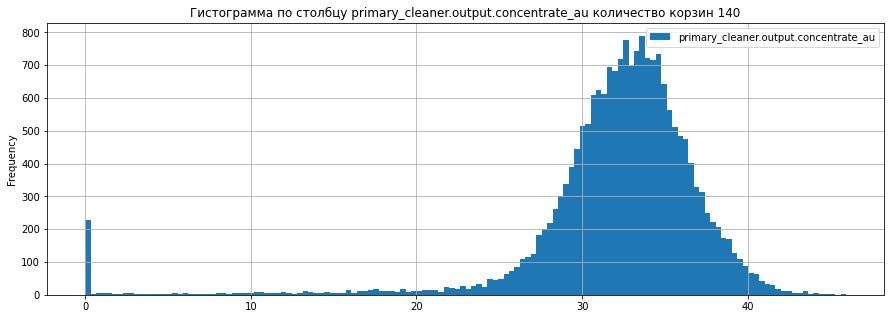

count    19439.000000
mean        32.119400
std          5.627611
min          0.000000
25%         30.463140
50%         32.841295
75%         35.048006
max         45.933934
Name: primary_cleaner.output.concentrate_au, dtype: float64

0.010000     117
0.000000     108
30.350809      6
27.765463      5
36.306431      5
            ... 
36.108676      1
32.090403      1
32.920681      1
38.134179      1
33.611983      1
Name: primary_cleaner.output.concentrate_au, Length: 19199, dtype: int64

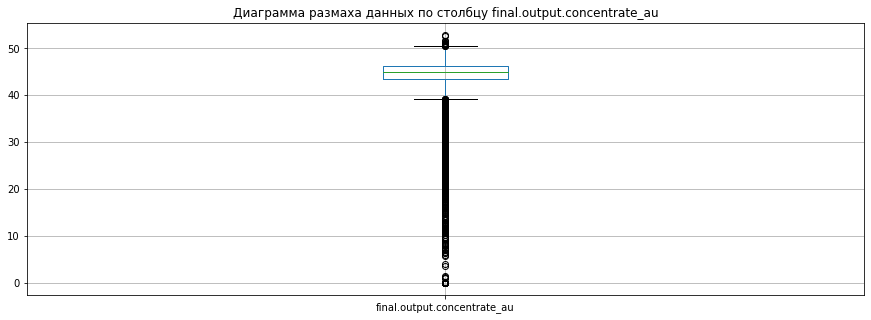

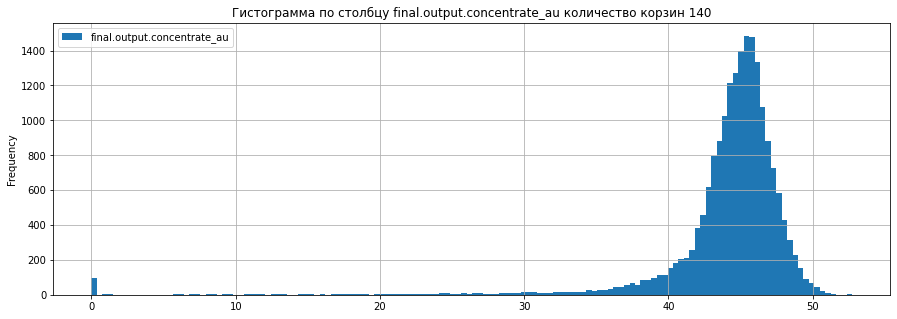

count    19439.000000
mean        44.076513
std          5.129784
min          0.000000
25%         43.402215
50%         45.011244
75%         46.275313
max         52.756638
Name: final.output.concentrate_au, dtype: float64

0.000000     98
37.336849    11
44.528214     7
46.105030     6
45.270618     5
             ..
43.058343     1
41.332039     1
43.590600     1
44.653469     1
47.956172     1
Name: final.output.concentrate_au, Length: 19308, dtype: int64

In [11]:
# Проанализируем концентрацию золота на каждом этапе.
parameters = [
    'rougher.output.concentrate_au', 
    'primary_cleaner.output.concentrate_au',          
    'final.output.concentrate_au'
]
for element in parameters:
    description(data, element)

**Золото**  
На всех стадиях значения концентрации золота распределены нормально. В каждом распределении присутствует аномалия в виде пиков на нулевых значениях (как и в случае с серебром и свинцом). Можно сделать предположение, что появление нулей оправдано и обусловлено непрерывностью процесса обогащения руды. Например, в момент снятия показаний новая партия сырья просто еще не прошла процесс флотации.
  
*Рассмотрим концентрации:*
* Флотация. Медианное значение концентрации золотоа: 20,3 %
* Первичная очистка. Медианное значение концентрации золота: 32,8 %
* Финальный концентрат. Медианное значение концентрации золота: 45 %  
  
Различий в концентрации свинца между первичной очисткой и финальным концентратом практически нет.

In [12]:
# Зафиксируем результаты в виде таблицы
au_concentrate = pd.DataFrame(
    {
        'Флотация': [data['rougher.output.concentrate_au'].median()], 
        'Первичная очистка': [
            data['primary_cleaner.output.concentrate_au'].median()
        ], 
        'Финальный концентрат': [
            data['final.output.concentrate_au'].median()
        ]
    }, 
    index=[
        'Медианное значение концентрации золота'
    ]
)
display(au_concentrate)

,Флотация,Первичная очистка,Финальный концентрат
Медианное значение концентрации золота,20.280214,32.841295,45.011244


Можно сделать вывод, что практически с каждым этапом очистки руды концентрация серебра и свинца уменьшается, а золота — растет.  
  
  Далее рассмотрим распределение размеров гранул сырья на обучающей и тестовой выборках. Оценим, отличаются ли они, и если да, то на сколько.

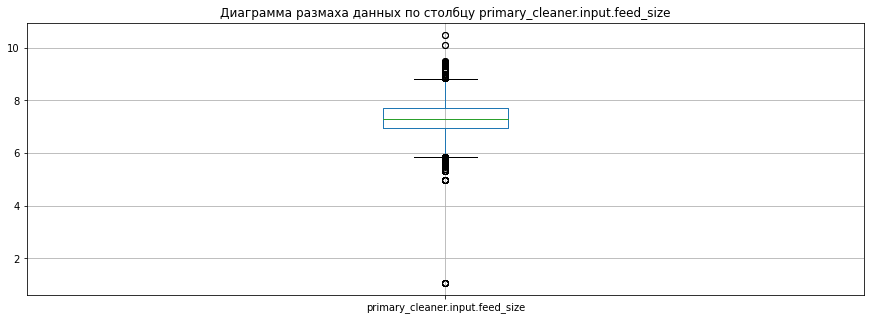

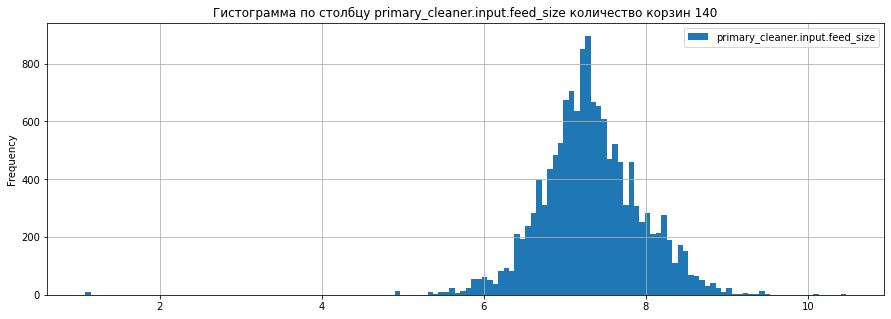

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

7.250000    312
7.000000    210
7.300000    204
7.700000    158
7.280000    144
           ... 
7.400000      1
7.260000      1
7.405000      1
7.945000      1
6.876666      1
Name: primary_cleaner.input.feed_size, Length: 3732, dtype: int64

In [13]:
# Проанализируем распределение размеров гранул сырья 
# на стадии входа во флотацию.
# Прокрутим через нашу функцию description 
# тренировочный и тестовый наборы.
description(train_data, 'primary_cleaner.input.feed_size')

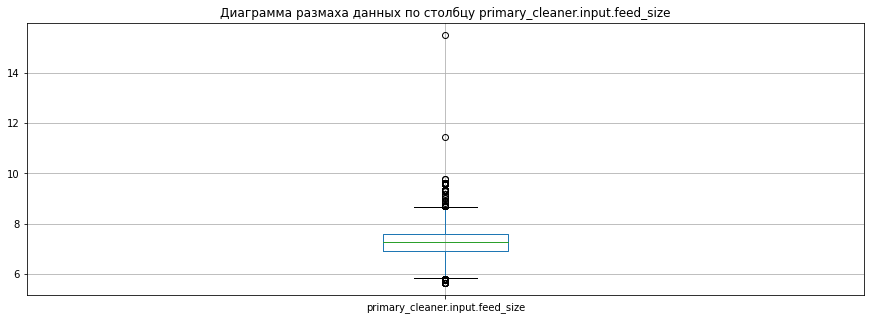

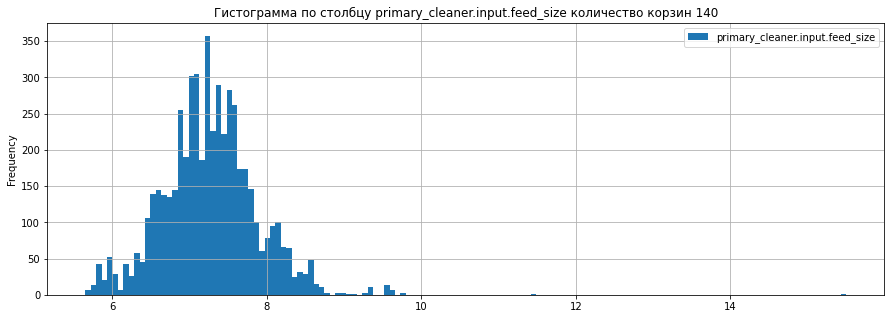

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

7.200000    124
7.100000     87
7.530000     77
7.830000     68
6.600000     65
           ... 
7.131000      1
6.900000      1
7.860000      1
5.880001      1
6.860000      1
Name: primary_cleaner.input.feed_size, Length: 1537, dtype: int64

In [14]:
# Теперь тестовую выборку.
description(test_data, 'primary_cleaner.input.feed_size')

В обоих случаях мы видим нормальное распределение. Медианы примерно равны и составляют около 7,3. Аномальные значения не сильно влияют на разницу между распределениями.  
Следующим шагом будет анализ суммарных концентраций всех веществ на разных стадиях.

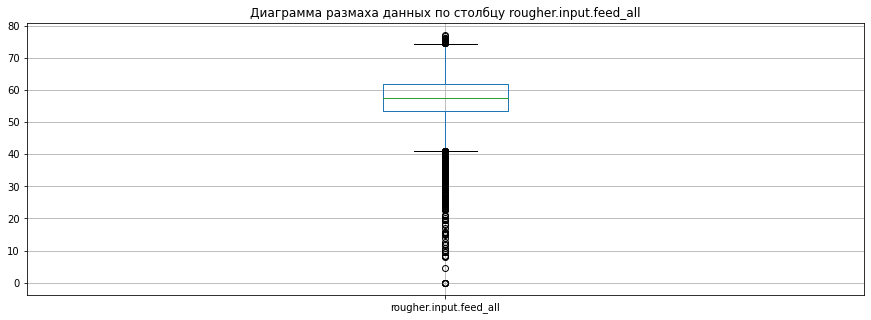

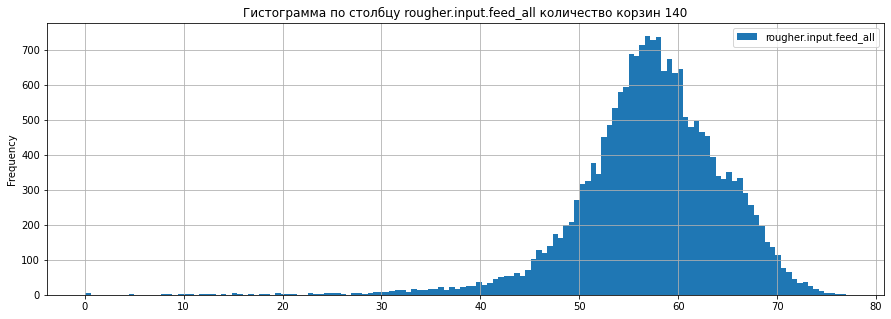

count    19439.000000
mean        57.320789
std          7.212680
min          0.040000
25%         53.557679
50%         57.594391
75%         61.953459
max         76.978947
Name: rougher.input.feed_all, dtype: float64

58.253792    10
60.283906     6
57.427033     5
0.040000      5
59.496087     5
             ..
56.221363     1
49.960590     1
61.849455     1
55.584540     1
58.621156     1
Name: rougher.input.feed_all, Length: 19409, dtype: int64

In [15]:
# Исследуем суммарную концентрацию всех веществ сырья.
data['rougher.input.feed_all'] = (
    data['rougher.input.feed_ag'] +
    data['rougher.input.feed_pb'] +
    data['rougher.input.feed_au'] +
    data['rougher.input.feed_sol']
)

description(data, 'rougher.input.feed_all')

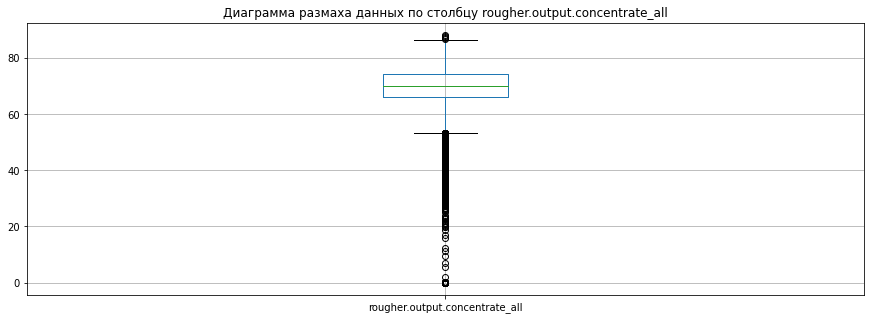

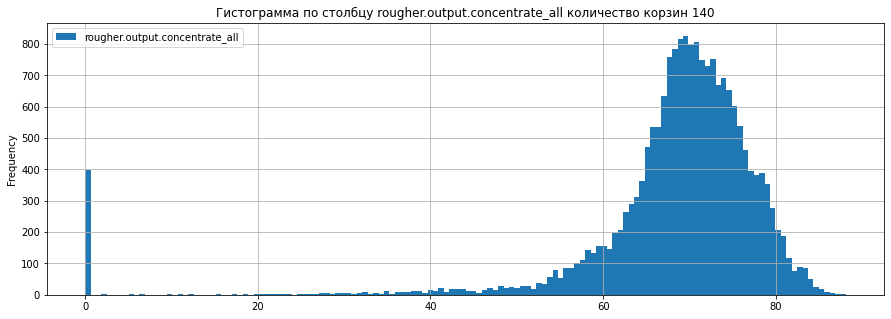

count    19439.000000
mean        68.170865
std         12.491279
min          0.000000
25%         66.012495
50%         70.181495
75%         74.356904
max         88.140119
Name: rougher.output.concentrate_all, dtype: float64

0.000000     394
41.115844     11
72.423889      6
67.824055      6
0.040000       5
            ... 
75.530758      1
62.958673      1
62.186166      1
72.755309      1
62.551079      1
Name: rougher.output.concentrate_all, Length: 19015, dtype: int64

In [16]:
# Исследуем суммарную концентрацию всех веществ чернового концентрата.
data['rougher.output.concentrate_all'] = (
    data['rougher.output.concentrate_ag'] +
    data['rougher.output.concentrate_pb'] +
    data['rougher.output.concentrate_au'] +
    data['rougher.output.concentrate_sol']
)

description(data, 'rougher.output.concentrate_all')

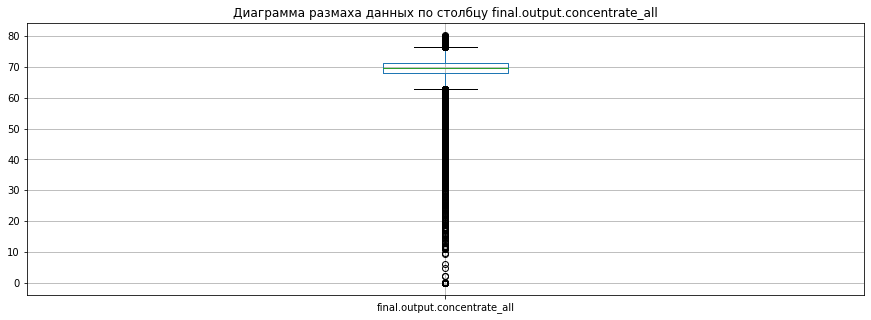

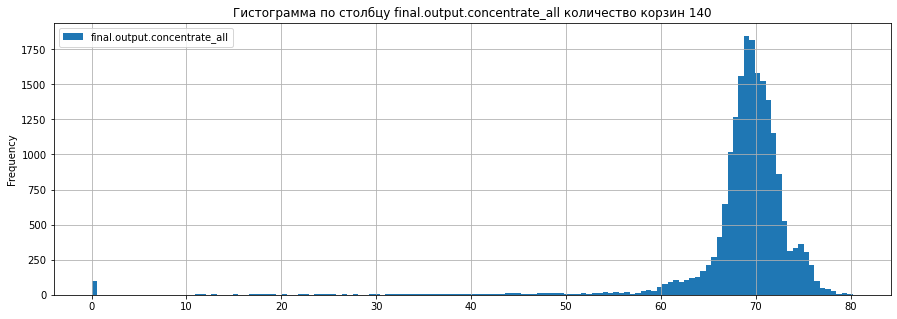

count    19439.000000
mean        68.653624
std          7.427536
min          0.000000
25%         67.932362
50%         69.598444
75%         71.368472
max         80.210644
Name: final.output.concentrate_all, dtype: float64

0.000000     98
64.690452    11
74.112068     7
69.425969     6
68.805134     5
             ..
72.085021     1
69.064330     1
71.039777     1
71.484719     1
69.504195     1
Name: final.output.concentrate_all, Length: 19308, dtype: int64

In [17]:
# Исследуем суммарную концентрацию всех веществ финального концентрата.
data['final.output.concentrate_all'] = (
    data['final.output.concentrate_ag'] +
    data['final.output.concentrate_pb'] +
    data['final.output.concentrate_au'] +
    data['final.output.concentrate_sol']
)

description(data, 'final.output.concentrate_all')

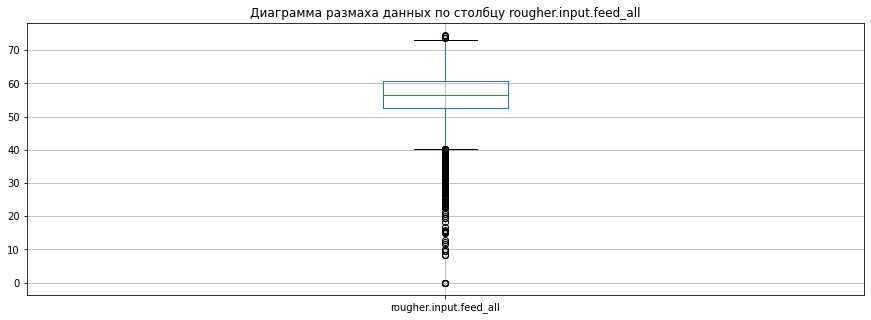

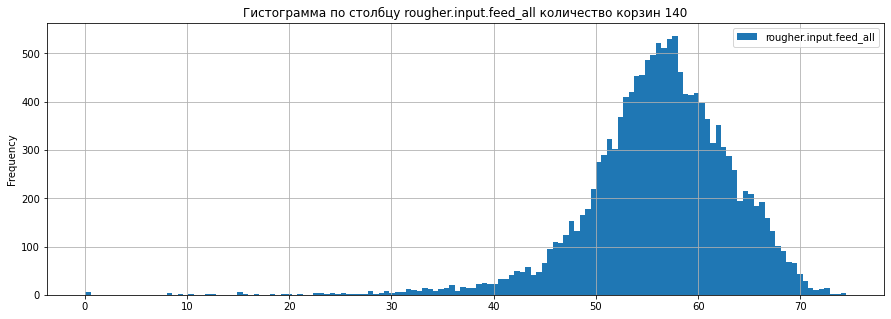

count    14149.000000
mean        56.242170
std          7.029808
min          0.040000
25%         52.573579
50%         56.627635
75%         60.763234
max         74.458253
Name: rougher.input.feed_all, dtype: float64

58.253792    10
57.427033     5
0.040000      5
59.496087     5
56.928130     3
             ..
47.977189     1
54.709399     1
56.372533     1
58.026193     1
58.621156     1
Name: rougher.input.feed_all, Length: 14126, dtype: int64

In [18]:
# Теперь проделаем то же самое с тренировочной выборкой
# Исследуем суммарную концентрацию всех веществ сырья 
# в тренировочной выборке.
train_data['rougher.input.feed_all'] = (
    train_data['rougher.input.feed_ag'] +
    train_data['rougher.input.feed_pb'] +
    train_data['rougher.input.feed_au'] +
    train_data['rougher.input.feed_sol']
)

description(train_data, 'rougher.input.feed_all')

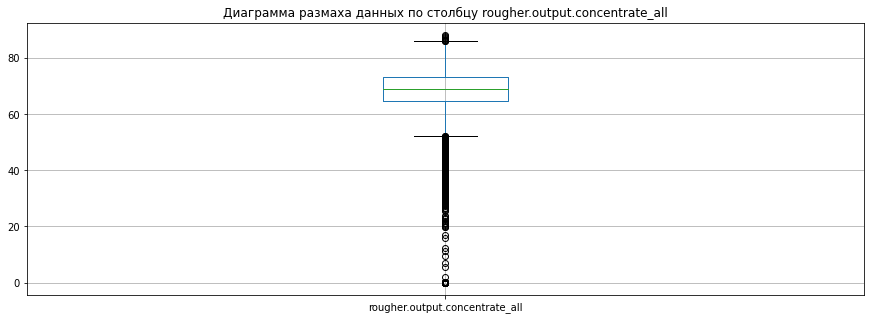

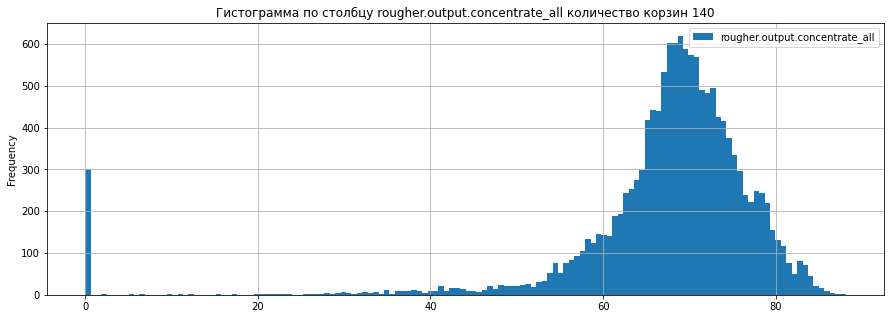

count    14149.000000
mean        67.173145
std         12.713129
min          0.000000
25%         64.914390
50%         69.175663
75%         73.429261
max         88.140119
Name: rougher.output.concentrate_all, dtype: float64

0.000000     297
41.115844     11
72.423889      6
0.040000       5
62.046453      4
            ... 
66.750014      1
73.726110      1
71.580219      1
69.947642      1
62.551079      1
Name: rougher.output.concentrate_all, Length: 13829, dtype: int64

In [19]:
# Исследуем суммарную концентрацию всех веществ чернового концентрата 
# в тренировочной выборке.
train_data['rougher.output.concentrate_all'] = (
    train_data['rougher.output.concentrate_ag'] +
    train_data['rougher.output.concentrate_pb'] +
    train_data['rougher.output.concentrate_au'] +
    train_data['rougher.output.concentrate_sol']
)

description(train_data, 'rougher.output.concentrate_all')

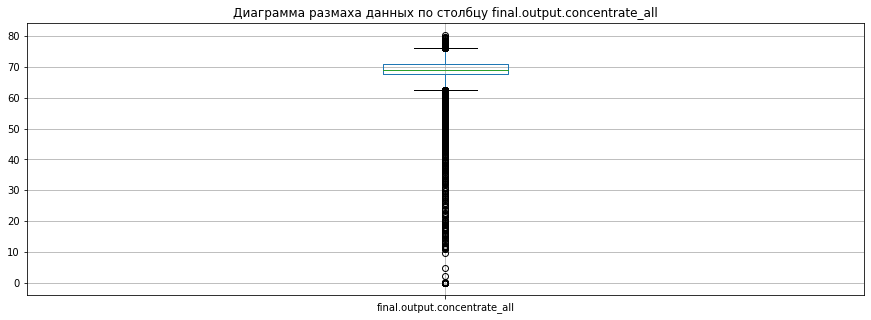

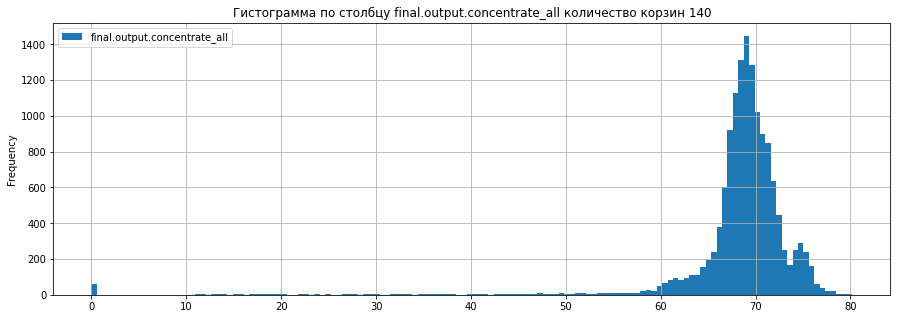

count    14149.000000
mean        68.387872
std          7.023723
min          0.000000
25%         67.559819
50%         69.141502
75%         70.974661
max         80.210644
Name: final.output.concentrate_all, dtype: float64

0.000000     58
64.690452    11
74.112068     7
67.946259     5
68.805134     5
             ..
68.353154     1
71.484719     1
71.039777     1
72.085021     1
59.865549     1
Name: final.output.concentrate_all, Length: 14065, dtype: int64

In [20]:
# Исследуем суммарную концентрацию всех веществ финального концентрата 
# в тренировочной выборке.
train_data['final.output.concentrate_all'] = (
    train_data['final.output.concentrate_ag'] +
    train_data['final.output.concentrate_pb'] +
    train_data['final.output.concentrate_au'] +
    train_data['final.output.concentrate_sol']
)

description(train_data, 'final.output.concentrate_all')

Алгоритмы машинного обучения чувствительны к диапазону и распределению значений в наборе данных. Выбросы данных могут испортить и ввести в заблуждение процесс обучения, что приведет к увеличению времени обучения, менее точным моделям и, в конечном итоге, к худшим результатам. Избавимся от выбросов в тренировочной выборке, находящихся за пределами "усов".

In [21]:
# Напишем функцию, позволяющую исключать из выборки данные, 
# лежащие за пределами "усов".

def iqr_cut (data,column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered_data = data[
        (data[column] >= lower) 
        & 
        (data[column] <= upper)
    ]
    return filtered_data

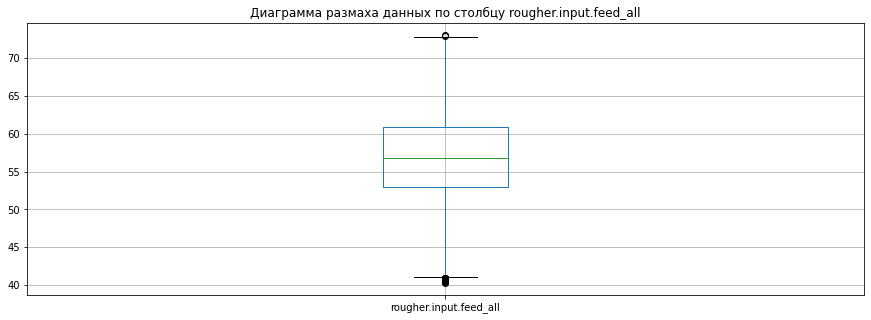

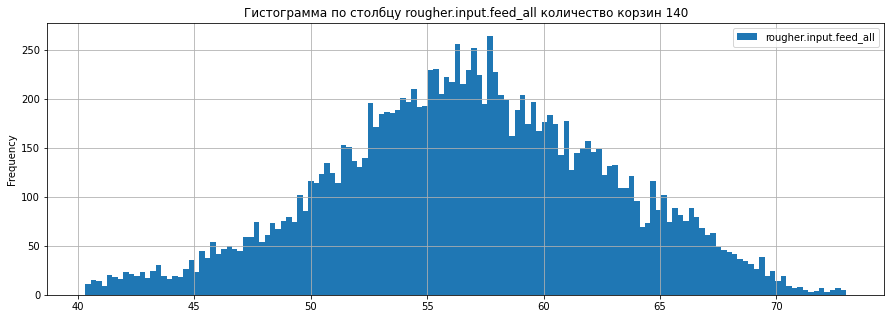

count    13803.000000
mean        56.811298
std          5.941147
min         40.316082
25%         52.927205
50%         56.793253
75%         60.901397
max         72.993238
Name: rougher.input.feed_all, dtype: float64

58.253792    10
59.496087     5
57.427033     5
56.928130     3
57.411676     1
             ..
46.533604     1
62.561531     1
55.997092     1
61.609113     1
58.621156     1
Name: rougher.input.feed_all, Length: 13784, dtype: int64

In [22]:
# Удалим выбросы суммарной концентрации веществ, 
# встречающиеся до начала флотации.
filtered_train_data_rougher_input = iqr_cut(train_data, 
                                            'rougher.input.feed_all')
# Проверим обновленный тренировочный набор.
description(filtered_train_data_rougher_input, 
            'rougher.input.feed_all')

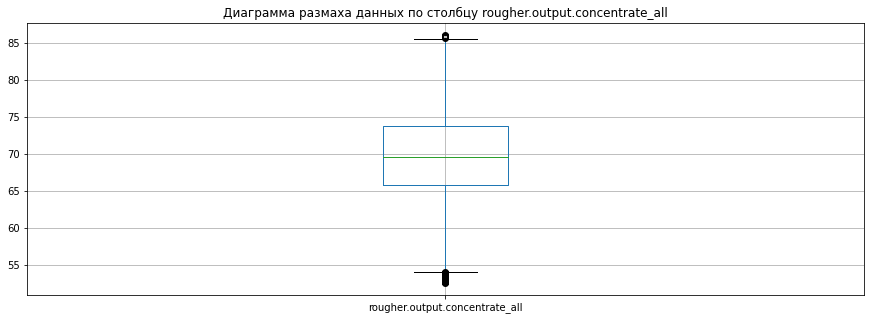

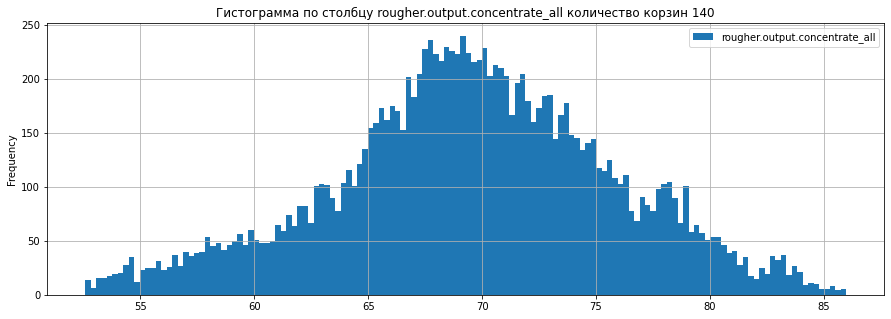

count    13144.000000
mean        69.561014
std          6.219405
min         52.575475
25%         65.789436
50%         69.580311
75%         73.678481
max         85.980989
Name: rougher.output.concentrate_all, dtype: float64

72.423889    6
62.046453    4
69.637081    3
65.591458    1
55.029857    1
            ..
79.323858    1
64.137093    1
70.858177    1
68.693064    1
62.551079    1
Name: rougher.output.concentrate_all, Length: 13134, dtype: int64

In [23]:
# Также избавимся от выбросов на стадии чернового концентрата.
filtered_train_data_rougher_output = iqr_cut(
    filtered_train_data_rougher_input, 
    'rougher.output.concentrate_all'
)
# Проверим обновленный тренировочный набор.
description(filtered_train_data_rougher_output, 
            'rougher.output.concentrate_all')

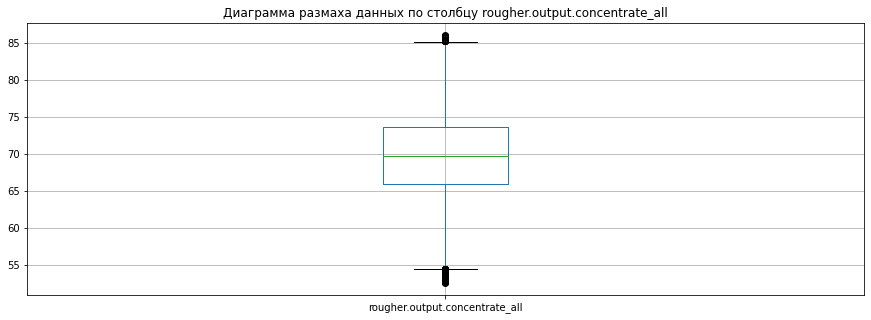

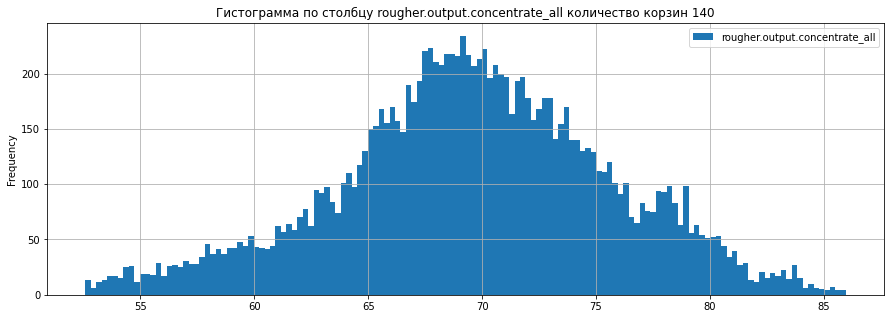

count    12339.000000
mean        69.607597
std          6.037126
min         52.575475
25%         65.927554
50%         69.628832
75%         73.593770
max         85.980989
Name: rougher.output.concentrate_all, dtype: float64

72.423889    6
62.046453    4
69.637081    3
80.090692    1
69.828138    1
            ..
73.751782    1
71.909693    1
60.202551    1
59.403921    1
70.409911    1
Name: rougher.output.concentrate_all, Length: 12329, dtype: int64

In [24]:
# Также избавимся от выбросов на стадии финального продукта.
filtered_train_data_final_output = iqr_cut(
    filtered_train_data_rougher_output, 
    'final.output.concentrate_all'
)
# Проверим обновленный тренировочный набор.
description(filtered_train_data_final_output, 
            'rougher.output.concentrate_all')

In [25]:
# Создадим новую переменную.
fltrd_train_data = filtered_train_data_final_output

### Вывод

Мы рассмотрели концентрации каждого металла на каждом этапе обогащения руды. Выявили, что с каждым этапом обогащения концентрация золота увеличивается, концентрация других металлов уменьшается.  
Результаты представлены в таблице.

In [26]:
conc_results = pd.concat([ag_concentrate, pb_concentrate, au_concentrate])
display(conc_results)

,Флотация,Первичная очистка,Финальный концентрат
Медианное значение концентрации серебра,12.098115,8.507298,5.066039
Медианное значение концентрации свинца,7.742580,10.142270,10.102264
Медианное значение концентрации золота,20.280214,32.841295,45.011244


В каждом распределении присутствует аномалия в виде пиков на нулевых значениях. Можно сделать предположение, что появление нулей оправдано и обусловлено непрерывностью процесса обогащения руды. Например, в момент снятия показаний новая партия сырья просто еще не прошла процесс флотации.

Мы рассмотрели распределения размеров гранул сырья на обучающей и тестовой выборках и признали, что распределения практически одинаковы.

Также мы рассмотрели распределение суммарных концентраций всех веществ на всех этапах обогащения в тренировочной выборке. Было принято решение избавиться от выбросов, чтобы обеспечить качественный процесс обучения будущей математической модели. Обработанная тренировочная выборка сохранена в переменной fltrd_train_data.

Следующими шагами будут:
1. Создание функции расчета итогового sMAPE  
2. Определение корреляции между целевыми признаками и другими признаками
3. Стандартизация признаков тренировочного набора
4. Обучение и проверка нескольких моделей
5. Выбор лучшей модели, проверка её качества на тестовой выборке

## Модель

In [27]:
# Создадим функцию расчета sMAPE.
# Параметрами функции будут правильные ответы и предсказания.
def smape(predictions, target, **kwargs):
    smape = ((abs(target - predictions)) / 
             ((abs(target) + abs(predictions)) / 2)).sum() / len(target)
    return smape

In [28]:
# Определим признаки, наиболее сильно влияющие на целевые признаки.
# Начнем с rougher.output.recovery.
# Создадим срез столбцов для анализа.
fltrd_train_data_corrs_rougher = fltrd_train_data[[
    'rougher.output.recovery',                                       
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level'
]]
correlations = fltrd_train_data_corrs_rougher.corr()
display(correlations.loc['rougher.output.recovery'].
        sort_values(ascending=False))

rougher.output.recovery               1.000000
rougher.state.floatbank10_a_air       0.434896
rougher.input.feed_ag                 0.388153
rougher.state.floatbank10_a_level     0.372045
rougher.input.feed_pb                 0.361048
rougher.input.feed_au                 0.337851
rougher.input.floatbank10_xanthate    0.292072
rougher.input.feed_sol                0.282495
rougher.input.floatbank11_xanthate    0.259143
rougher.input.feed_size               0.129785
rougher.input.feed_rate               0.020574
rougher.input.floatbank11_sulfate    -0.089298
rougher.input.floatbank10_sulfate    -0.103946
rougher.state.floatbank10_f_air      -0.144513
rougher.state.floatbank10_e_level    -0.214211
rougher.state.floatbank10_e_air      -0.214779
rougher.state.floatbank10_c_level    -0.216039
rougher.state.floatbank10_f_level    -0.216446
rougher.state.floatbank10_d_level    -0.216623
rougher.state.floatbank10_b_level    -0.217651
rougher.state.floatbank10_b_air      -0.275242
rougher.state

In [29]:
# Теперь проверим корреляцию признаков с 
# целевым признаком final.output.recovery.
fltrd_train_data_corrs_final = fltrd_train_data[[
    'final.output.recovery',
    'primary_cleaner.input.sulfate',
    'primary_cleaner.input.depressant',
    'primary_cleaner.input.feed_size',
    'primary_cleaner.input.xanthate',
    'primary_cleaner.state.floatbank8_a_air',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_b_air',
    'primary_cleaner.state.floatbank8_b_level',
    'primary_cleaner.state.floatbank8_c_air',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_d_air',
    'primary_cleaner.state.floatbank8_d_level',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_air',
    'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_air',
    'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_air',
    'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_air',
    'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_air',
    'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_air',
    'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_air',
    'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_air',
    'secondary_cleaner.state.floatbank6_a_level'
]]
correlations = fltrd_train_data_corrs_final.corr()
display(correlations.loc['final.output.recovery'].sort_values(
    ascending=False
)
       )

final.output.recovery                         1.000000
primary_cleaner.input.sulfate                 0.363711
rougher.input.feed_ag                         0.347373
rougher.input.floatbank10_xanthate            0.341605
rougher.input.feed_au                         0.333007
rougher.input.floatbank11_xanthate            0.315974
rougher.state.floatbank10_a_air               0.245262
primary_cleaner.input.xanthate                0.230347
secondary_cleaner.state.floatbank4_a_air      0.218921
primary_cleaner.state.floatbank8_b_air        0.205570
secondary_cleaner.state.floatbank3_a_air      0.200925
primary_cleaner.state.floatbank8_c_air        0.198760
secondary_cleaner.state.floatbank4_b_air      0.192649
primary_cleaner.state.floatbank8_a_air        0.189817
rougher.input.feed_pb                         0.188905
rougher.input.feed_sol                        0.188857
secondary_cleaner.state.floatbank2_a_air      0.167063
secondary_cleaner.state.floatbank2_b_air      0.166407
primary_cl

К сожалению, метод `corr()` не отражает оценку нелинейных зависимостей. Тем не менее мы вполне можем начать выбор влияющих признаков, опираясь на результаты этого метода.  
Возьмем в качестве порога коэффициент Пирсона 0,2 (модуль) для целевого признака `rougher.output.recovery`.   
Для целевого признака `final.output.recovery` возьмем порог 0,1 (модуль). Всё, что больше мы оставляем. Всё, что меньше — убираем.  
  
Между целевым признаком `rougher.output.recovery` и другими признаками присутствует взаимосвязь:  
  
  *Прямая:*  
* `rougher.state.floatbank10_a_air`      
* `rougher.input.feed_ag`                
* `rougher.state.floatbank10_a_level`     
* `rougher.input.feed_pb`                
* `rougher.input.feed_au`                
* `rougher.input.floatbank10_xanthate`   
* `rougher.input.feed_sol`                
* `rougher.input.floatbank11_xanthate`   
  
*Обратная:*  
    
* `rougher.state.floatbank10_e_level`    
* `rougher.state.floatbank10_e_air`     
* `rougher.state.floatbank10_c_level`    
* `rougher.state.floatbank10_f_leve`  
* `rougher.state.floatbank10_d_level`   
* `rougher.state.floatbank10_b_level`    
* `rougher.state.floatbank10_b_air`     
* `rougher.state.floatbank10_d_air`      
* `rougher.state.floatbank10_c_air`       
  
Используем их в качестве признаков `features` для нашей модели, предсказывающей значения `rougher.output.recovery`.  
  
Между целевым признаком `final.output.recovery` и другими признаками присутствует взаимосвязь:  
  
*Прямая:*  

* `primary_cleaner.input.sulfate`
* `rougher.input.feed_ag`
* `rougher.input.floatbank10_xanthate`
* `rougher.input.feed_au`
* `rougher.input.floatbank11_xanthate`
* `rougher.state.floatbank10_a_air`
* `primary_cleaner.input.xanthate`
* `secondary_cleaner.state.floatbank4_a_air`
* `primary_cleaner.state.floatbank8_b_air`
* `secondary_cleaner.state.floatbank3_a_air`
* `primary_cleaner.state.floatbank8_c_air`
* `secondary_cleaner.state.floatbank4_b_air`
* `primary_cleaner.state.floatbank8_a_air`
* `rougher.input.feed_pb`
* `rougher.input.feed_sol`
* `secondary_cleaner.state.floatbank2_a_air`
* `secondary_cleaner.state.floatbank2_b_air`
* `primary_cleaner.input.depressant`
* `rougher.input.feed_rate`
* `primary_cleaner.state.floatbank8_a_level`
* `primary_cleaner.state.floatbank8_c_level`
* `primary_cleaner.state.floatbank8_b_level`
  
*Обратная:*  
  
* `secondary_cleaner.state.floatbank4_b_level`
* `rougher.state.floatbank10_b_air`
* `rougher.state.floatbank10_d_air`
* `rougher.state.floatbank10_c_air`

Используем их в качестве признаков `features` для нашей модели, предсказывающей значения `final.output.recovery`.  

### Целевой признак rougher.output.recovery

In [30]:
# Подготовим признаки и целевой признак для 
# предсказания rougher.output.recovery.
features_rougher = fltrd_train_data[[                                       
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_level',
    'rougher.input.floatbank11_xanthate'
]]
target_rougher = fltrd_train_data['rougher.output.recovery']

In [31]:
# Масштабируем численные количественные признаки 
# тренировочной выборки.
scaler = StandardScaler()
features_rougher = pd.DataFrame(
    scaler.fit_transform(features_rougher),
    columns = features_rougher.columns
)

#### Модель случайного леса

In [32]:
# Подберем лучшую модель для предсказания rougher.output.recovery
# Обучим модель случайного леса и проверим её качество кросс-валидацией,
# подбирая различные гиперпараметры. Начнём с максимальной глубины деревьев.
for depth in range(1, 16, 1):
    model = RandomForestRegressor(
        n_estimators=20, 
        max_depth=depth, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print('depth = ',depth, 'Средняя sMAPE модели составляет', final_score)

depth =  1 Средняя sMAPE модели составляет 0.07074513025617649
depth =  2 Средняя sMAPE модели составляет 0.06425639759762096
depth =  3 Средняя sMAPE модели составляет 0.0569681099394869
depth =  4 Средняя sMAPE модели составляет 0.05748411851916101
depth =  5 Средняя sMAPE модели составляет 0.05847914684056306
depth =  6 Средняя sMAPE модели составляет 0.058738077935750845
depth =  7 Средняя sMAPE модели составляет 0.05845276871854347
depth =  8 Средняя sMAPE модели составляет 0.05858067206701643
depth =  9 Средняя sMAPE модели составляет 0.05943833970117355
depth =  10 Средняя sMAPE модели составляет 0.059732823561576484
depth =  11 Средняя sMAPE модели составляет 0.060211645142453654
depth =  12 Средняя sMAPE модели составляет 0.060612163380434056
depth =  13 Средняя sMAPE модели составляет 0.060760018826154304
depth =  14 Средняя sMAPE модели составляет 0.06089898207196006
depth =  15 Средняя sMAPE модели составляет 0.06158616297270608


In [33]:
# Лучше всех показала себя максимальная глубина дерева 3.
# Теперь подберем количество оценщиков.
for estimators in range(10, 110, 10):
    model = RandomForestRegressor(
        n_estimators=estimators, 
        max_depth=3, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print('n_estimators = ',estimators, 'Средняя sMAPE модели составляет', 
          final_score)

n_estimators =  10 Средняя sMAPE модели составляет 0.05658492927648402
n_estimators =  20 Средняя sMAPE модели составляет 0.0569681099394869
n_estimators =  30 Средняя sMAPE модели составляет 0.05703375023606041
n_estimators =  40 Средняя sMAPE модели составляет 0.05705232254689572
n_estimators =  50 Средняя sMAPE модели составляет 0.05701568435053463
n_estimators =  60 Средняя sMAPE модели составляет 0.0569570634163287
n_estimators =  70 Средняя sMAPE модели составляет 0.0569221355467134
n_estimators =  80 Средняя sMAPE модели составляет 0.056875848932979624
n_estimators =  90 Средняя sMAPE модели составляет 0.05684519044671364
n_estimators =  100 Средняя sMAPE модели составляет 0.0569156870558077


In [34]:
# Лучше всего себя показало количество оценщиков равное 10.
# Зафиксируем результат.
model_rougher_rf = RandomForestRegressor(
    n_estimators=10, 
    max_depth=3, 
    random_state=12345
)
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_rougher_rf, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Средняя sMAPE модели случайного леса, предсказывающей' +
    ' rougher.output.recovery, составляет {:.2%}'.
    format(final_score))
rougher_rf_smape = final_score

Средняя sMAPE модели случайного леса, предсказывающей rougher.output.recovery, составляет 5.66%


#### Модель линейной регрессии

In [35]:
# Обучим модель линейной регрессии и проверим её качество кросс-валидацией.
model_rougher_lr = LinearRegression()
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_rougher_lr, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Средняя sMAPE модели линейной регрессии, предсказывающей' +
    ' rougher.output.recovery, составляет {:.2%}'.format(final_score))
rougher_lr_smape = final_score

Средняя sMAPE модели линейной регрессии, предсказывающей rougher.output.recovery, составляет 6.04%


#### Модель дерева решений

In [36]:
# Обучим модель дерева решений и проверим её качество кросс-валидацией.
# Подберем максимальную глубину деревьев.
for depth in range(1, 16, 1):
    model = DecisionTreeRegressor(
        max_depth=depth, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print('depth = ',depth, 'Средняя sMAPE модели составляет', final_score)

depth =  1 Средняя sMAPE модели составляет 0.07101198194533857
depth =  2 Средняя sMAPE модели составляет 0.0661623653412378
depth =  3 Средняя sMAPE модели составляет 0.05759543364335131
depth =  4 Средняя sMAPE модели составляет 0.05907047617978702
depth =  5 Средняя sMAPE модели составляет 0.061126953166756884
depth =  6 Средняя sMAPE модели составляет 0.06553296701153818
depth =  7 Средняя sMAPE модели составляет 0.06417782659626897
depth =  8 Средняя sMAPE модели составляет 0.06509059929270002
depth =  9 Средняя sMAPE модели составляет 0.06582460770073476
depth =  10 Средняя sMAPE модели составляет 0.06463930521800618
depth =  11 Средняя sMAPE модели составляет 0.06698987700215035
depth =  12 Средняя sMAPE модели составляет 0.06896609577592931
depth =  13 Средняя sMAPE модели составляет 0.07145040511025923
depth =  14 Средняя sMAPE модели составляет 0.07149531015697683
depth =  15 Средняя sMAPE модели составляет 0.07329964052631754


In [37]:
# Лучше всего себя показала максимальная глубина деревьев равная 3.
# Зафиксируем результат
model_rougher_dt = DecisionTreeRegressor(
    max_depth=3, 
    random_state=12345
)
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_rougher_dt, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Средняя sMAPE модели дерева решений, предсказывающей' +
    ' rougher.output.recovery, составляет {:.2%}'.
    format(final_score))
rougher_dt_smape = final_score

Средняя sMAPE модели дерева решений, предсказывающей rougher.output.recovery, составляет 5.76%


### Целевой признак final.output.recovery

In [38]:
# Подготовим признаки и целевой признак 
# для предсказания final.output.recovery.
features_final = fltrd_train_data[[
    'primary_cleaner.input.sulfate',
    'rougher.input.feed_ag',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.feed_au',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'primary_cleaner.input.xanthate',
    'secondary_cleaner.state.floatbank4_a_air',
    'primary_cleaner.state.floatbank8_b_air',
    'secondary_cleaner.state.floatbank3_a_air',
    'primary_cleaner.state.floatbank8_c_air',
    'secondary_cleaner.state.floatbank4_b_air',
    'primary_cleaner.state.floatbank8_a_air',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_b_air',
    'primary_cleaner.input.depressant',
    'rougher.input.feed_rate',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_b_level',
    'secondary_cleaner.state.floatbank4_b_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_c_air',
]]
target_final = fltrd_train_data['final.output.recovery']

In [39]:
# Масштабируем численные количественные признаки тренировочной выборки.
scaler = StandardScaler()
features_final = pd.DataFrame(
    scaler.fit_transform(features_final),
    columns = features_final.columns
)

#### Модель случайного леса

In [40]:
# Подберем лучшую модель для предсказания final.output.recovery
# Обучим модель случайного леса и проверим её качество кросс-валидацией,
# подбирая различные гиперпараметры. Начнём с максимальной глубины деревьев.
for depth in range(1, 16, 1):
    model = RandomForestRegressor(
        n_estimators=20, 
        max_depth=depth, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_final, 
    target_final, 
    scoring=my_scorer, 
    cv=5
    ))
    final_score = scores.mean()
    print('depth = ',depth, 'Средняя sMAPE модели составляет', final_score)

depth =  1 Средняя sMAPE модели составляет 0.08741286897412064
depth =  2 Средняя sMAPE модели составляет 0.08671923525847072
depth =  3 Средняя sMAPE модели составляет 0.08577589326929502
depth =  4 Средняя sMAPE модели составляет 0.08397767761699208
depth =  5 Средняя sMAPE модели составляет 0.08408747313895833
depth =  6 Средняя sMAPE модели составляет 0.08488968157290361
depth =  7 Средняя sMAPE модели составляет 0.08636398077127563
depth =  8 Средняя sMAPE модели составляет 0.08710925041241671
depth =  9 Средняя sMAPE модели составляет 0.0869033668989645
depth =  10 Средняя sMAPE модели составляет 0.08724497972871799
depth =  11 Средняя sMAPE модели составляет 0.08820151311570386
depth =  12 Средняя sMAPE модели составляет 0.08766500127672795
depth =  13 Средняя sMAPE модели составляет 0.08910521633117952
depth =  14 Средняя sMAPE модели составляет 0.08877524935218825
depth =  15 Средняя sMAPE модели составляет 0.08903086965078927


In [41]:
# Лучше всех показала себя максимальная глубина дерева 4.
# Теперь подберем количество оценщиков.
for estimators in range(10, 110, 10):
    model = RandomForestRegressor(
        n_estimators=estimators, 
        max_depth=4, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_final, 
    target_final,
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print(
        'n_estimators = ',estimators, 'Средняя sMAPE модели составляет', 
        final_score)

n_estimators =  10 Средняя sMAPE модели составляет 0.08313995556607884
n_estimators =  20 Средняя sMAPE модели составляет 0.08282005835682435
n_estimators =  30 Средняя sMAPE модели составляет 0.0827248751465931
n_estimators =  40 Средняя sMAPE модели составляет 0.08249553617425984
n_estimators =  50 Средняя sMAPE модели составляет 0.08230023253278983
n_estimators =  60 Средняя sMAPE модели составляет 0.08226139055724577
n_estimators =  70 Средняя sMAPE модели составляет 0.08226678642236
n_estimators =  80 Средняя sMAPE модели составляет 0.08225607572779772
n_estimators =  90 Средняя sMAPE модели составляет 0.08217189393963122
n_estimators =  100 Средняя sMAPE модели составляет 0.0821820660443757


In [42]:
# Лучше всего себя показало количество оценщиков равное 90.
# Зафиксируем результат.
model_final_rf = RandomForestRegressor(
    n_estimators=90, 
    max_depth=4, 
    random_state=12345
)
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_final_rf, 
    features_final, 
    target_final,
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Средняя sMAPE модели случайного леса, предсказывающей' +
    ' final.output.recovery, составляет {:.2%}'.
    format(final_score))
final_rf_smape = final_score

Средняя sMAPE модели случайного леса, предсказывающей final.output.recovery, составляет 8.22%


#### Модель линейной регрессии

In [43]:
# Обучим модель линейной регрессии и проверим её качество кросс-валидацией.
model_final_lr = LinearRegression()
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_final_lr, 
    features_final, 
    target_final,
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Средняя sMAPE модели линейной регрессии, предсказывающей' +
    ' final.output.recovery, составляет {:.2%}'.
    format(final_score))
final_lr_smape = final_score

Средняя sMAPE модели линейной регрессии, предсказывающей final.output.recovery, составляет 8.88%


#### Модель дерева решений

In [44]:
# Обучим модель дерева решений и проверим её качество кросс-валидацией.
# Подберем максимальную глубину деревьев.
for depth in range(1, 16, 1):
    model = DecisionTreeRegressor(
        max_depth=depth, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_final, 
    target_final, 
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print('depth = ',depth, 'Средняя sMAPE модели составляет', final_score)

depth =  1 Средняя sMAPE модели составляет 0.08588682046862849
depth =  2 Средняя sMAPE модели составляет 0.0882726195028254
depth =  3 Средняя sMAPE модели составляет 0.0880194579604236
depth =  4 Средняя sMAPE модели составляет 0.08690598954656636
depth =  5 Средняя sMAPE модели составляет 0.0913586950293634
depth =  6 Средняя sMAPE модели составляет 0.09291077936439597
depth =  7 Средняя sMAPE модели составляет 0.0970513630998307
depth =  8 Средняя sMAPE модели составляет 0.1056262776369
depth =  9 Средняя sMAPE модели составляет 0.10789444561198505
depth =  10 Средняя sMAPE модели составляет 0.10854558240151779
depth =  11 Средняя sMAPE модели составляет 0.11470997674702735
depth =  12 Средняя sMAPE модели составляет 0.12006924999474022
depth =  13 Средняя sMAPE модели составляет 0.12124516634233007
depth =  14 Средняя sMAPE модели составляет 0.12011100255634125
depth =  15 Средняя sMAPE модели составляет 0.13044120297165174


In [45]:
# Лучше всего себя показала максимальная глубина деревьев равная 1.
# Зафиксируем результат.
model_final_dt = DecisionTreeRegressor(
    max_depth=1, 
    random_state=12345
)
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_final_dt, 
    features_final, 
    target_final, 
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Средняя sMAPE модели дерева решений, предсказывающей' +
    ' final.output.recovery, составляет {:.2%}'.
    format(final_score))
final_dt_smape = final_score

Средняя sMAPE модели дерева решений, предсказывающей final.output.recovery, составляет 8.59%


По результатам проверок лучшими моеделями являются:  
**Целевой признак rougher.output.recovery**  
Модель случайного леса. sMAPE = 5,66 %  
    
**Целевой признак final.output.recovery**  
Модель случайного леса. sMAPE = 8,22 %

In [46]:
# Оформим результаты в таблицу.
data_scores = pd.DataFrame(
    data={'Случайный лес': [rougher_rf_smape, final_rf_smape],
          'Линейная регрессия': [rougher_lr_smape, final_lr_smape],
          'Дерево решений': [rougher_dt_smape, final_dt_smape]},
    index=['rougher.output.recovery','final.output.recovery'])
data_scores.index.name = 'Наименование модели'
display(data_scores)

,Случайный лес,Линейная регрессия,Дерево решений
Наименование модели,,,
rougher.output.recovery,0.056585,0.060390,0.057595
final.output.recovery,0.082172,0.088829,0.085887


In [47]:
# Напишем функцию для расчета итогового sMAPE.
def final_smape(smape_rougher, smape_final):
    final_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return final_smape
# Подведем итоги расчета на тренировочной выборке
print('Итоговая sMAPE на тренировочной выборке составляет {:.2%}'.
      format(final_smape
    (data_scores.loc['rougher.output.recovery'].min(),
     data_scores.loc['final.output.recovery'].min())))

Итоговая sMAPE на тренировочной выборке составляет 7.58%


Проверим качество этих моделей на тестовой выборке. Посчитаем итоговый sMAPE. 

In [48]:
# Проверим качество на тестовой выборке.
# Подготовим правильные ответы.
# Сначала для rougher.output.recovery.
test_target_rougher = data['rougher.output.recovery'].loc[test_data.index]
# Теперь для final.output.recovery.
test_target_final = data['final.output.recovery'].loc[test_data.index]
# Оставим в тестовой выборке те признаки, которые 
# мы использовали для обучения.
test_features_rougher = test_data[[                                       
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_level',
    'rougher.input.floatbank11_xanthate'
]]
# Подготовим тестовую выборку для целевого признака final.output.recovery.
test_features_final = test_data[[                                       
    'primary_cleaner.input.sulfate',
    'rougher.input.feed_ag',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.feed_au',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'primary_cleaner.input.xanthate',
    'secondary_cleaner.state.floatbank4_a_air',
    'primary_cleaner.state.floatbank8_b_air',
    'secondary_cleaner.state.floatbank3_a_air',
    'primary_cleaner.state.floatbank8_c_air',
    'secondary_cleaner.state.floatbank4_b_air',
    'primary_cleaner.state.floatbank8_a_air',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_b_air',
    'primary_cleaner.input.depressant',
    'rougher.input.feed_rate',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_b_level',
    'secondary_cleaner.state.floatbank4_b_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_c_air'
]]

In [49]:
# Протестируем качество наших моделей.
# Начнем с целевого признака rougher.output.recovery.
model_rougher = RandomForestRegressor(
    n_estimators=10, 
    max_depth=3, 
    random_state=12345
)
model_rougher.fit(features_rougher, target_rougher)
predictions_rougher = pd.Series(
    model_rougher.predict(test_features_rougher), 
    index=test_target_rougher.index
    )
smape_rougher = smape(predictions_rougher, test_target_rougher)
print('sMAPE целевого признака rougher.output.recovery равна {:.2%}'.
      format(smape_rougher))

sMAPE целевого признака rougher.output.recovery равна 9.91%


In [50]:
# Взглянем на атрибут feature_importances,чтобы понять, какие признаки
# наиболее связаны с целевым признаком, а какие — наименее связаны.
def importance(model, features):
    importance = model.feature_importances_
    colums_features = features.columns 
    importance = pd.Series(importance, index=colums_features)
    importance.sort_values(ascending=False).plot(
        kind='bar', x=importance.index, y=importance,
        title='Гистограмма важности признаков'
    )

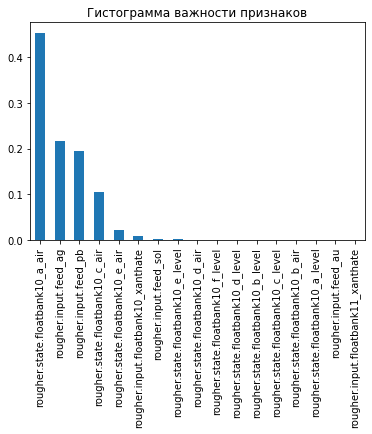

In [51]:
importance(model_rougher, test_features_rougher)

In [52]:
# Теперь целевой признак final.output.recovery.
model_final = RandomForestRegressor(
    n_estimators=90, 
    max_depth=4, 
    random_state=12345
)
model_final.fit(features_final, target_final)
predictions_final = pd.Series(
    model_final.predict(test_features_final), 
    index=test_target_final.index
    )
smape_final = smape(predictions_final, test_target_final)
print('sMAPE целевого признака rougher.output.recovery равна {:.2%}'.
      format(smape_final))

sMAPE целевого признака rougher.output.recovery равна 10.62%


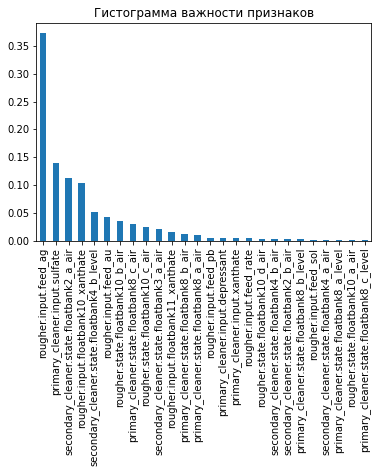

In [53]:
# Взглянем на атрибут feature_importances, чтобы понять, какие признаки
# наиболее связаны с целевым признаком, а какие — наименее связаны.
importance(model_final, test_features_final)

In [54]:
# Посчитаем итоговую sMAPE.
print('Итоговая sMAPE нашей модели на тестовой выборке составляет {:.2%}'.
      format(final_smape(smape_rougher, smape_final)))

Итоговая sMAPE нашей модели на тестовой выборке составляет 10.44%


### Вывод

Итоговая sMAPE на наших моделях оказалась равна 10,44 %.

## Вывод

Мы подготовили данные и провели их анализ. В рамках данных шагов мы изучили данные, проверили правильность расчета эффективности обогащения, избавились от пропусков и аномалий.  
Во время подготовки к построению моделей мы провели анализ корреляции, чтобы выявить связи признаков и целевыми признаками.  
Затем с помощью кросс-валидации испытали разные виды моделей, параллельно настраивая их гиперпараметры.  
Мы добились значения итоговой sMAPE равной 10.44 %.